# Dependencies

In [1]:
import numpy as np
import pickle
import random

from matplotlib import pyplot
from PIL import Image
from statistics import mode

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, RandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

# Loading

In [4]:
def extractData(file):
  with open(file, 'rb') as f: 
    data = pickle.load(f)
    return data

In [9]:
train = extractData("images_l.pkl")
labels = extractData("labels_l.pkl")
tempTrainX, tempTrainY = train, labels
print(f"Train X Shape: {tempTrainX.shape}, Train Y Shape: {tempTrainY.shape}")

unlabeled = extractData("images_ul.pkl")
print(f"Unlabeled X Shape: {unlabeled.shape}")

test = extractData("images_test.pkl")
tempTestX = test
print(f"Test X Shape: {tempTestX.shape}")

Train X Shape: (30000, 56, 56), Train Y Shape: (30000, 36)
Unlabeled X Shape: (30000, 56, 56)
Test X Shape: (15000, 56, 56)


# ResNet

In [13]:
class multiLayer(nn.Module):
  def __init__(self, in_channel, out_channel, downsample = None, stride = 1):
    super(multiLayer, self).__init__()
    self.expand = 4
    self.relu = nn.ReLU()
    self.downsample = downsample
    self.convL1 = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=1, padding=0)
    self.norm1 = nn.BatchNorm2d(out_channel)
    self.convL2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride, padding=1)
    self.norm2 = nn.BatchNorm2d(out_channel)
    self.convL3 = nn.Conv2d(out_channel, out_channel*self.expand, kernel_size=1, stride=1, padding=0)
    self.norm3 = nn.BatchNorm2d(out_channel*self.expand)   

  def forward(self,input):
    saved = input
    input = self.convL1(input)
    input = self.norm1(input)
    input = self.relu(input)
    input = self.convL2(input)
    input = self.norm2(input)
    input = self.relu(input)
    input = self.convL3(input)
    input = self.norm3(input)
    if (self.downsample is not None):
      saved = self.downsample(saved)
    input += saved
    input = self.relu(input)
    return input

class ResNet_prod(nn.Module):
  def __init__(self, multiLayer, layers, image_channels, num_classes):
    super(ResNet_prod, self).__init__()
    self.relu = nn.ReLU()
    self.in_channel = 64
    self.convL1 = nn.Conv2d(image_channels, 64, kernel_size=7,stride=2,padding=3)
    self.norm1 = nn.BatchNorm2d(64)
    self.max_pooling = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    self.lay1 = self.layer_prod(multiLayer, stride=1,out_channel=64,res_blocks=layers[0])
    self.lay2 = self.layer_prod(multiLayer, stride=2,out_channel=128,res_blocks=layers[1])
    self.lay3 = self.layer_prod(multiLayer, stride=2,out_channel=256,res_blocks=layers[2])
    self.lay4 = self.layer_prod(multiLayer, stride=2,out_channel=512,res_blocks=layers[3])
    self.avgPool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512*4, num_classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self,input):
    saved = input
    input = self.convL1(input)
    input = self.norm1(input)
    input = self.relu(input)
    input = self.max_pooling(input)
    input = self.lay1(input)
    input = self.lay2(input)
    input = self.lay3(input)
    input = self.lay4(input)
    input = self.avgPool(input)
    input = input.reshape(input.shape[0], -1)
    input = self.fc(input)
    input = self.sigmoid(input)
    return input

  def layer_prod(self, multiLayer, out_channel, stride, res_blocks):
    layers = []
    downsample = None
    if (stride != 1 or self.in_channel != out_channel*4):
      conv = nn.Conv2d(self.in_channel, out_channel*4,kernel_size=1,stride=stride)
      norm = nn.BatchNorm2d(out_channel*4)
      downsample = nn.Sequential(conv,norm)
    l = multiLayer(self.in_channel,out_channel,downsample,stride)
    self.in_channel = out_channel*4
    layers.append(l)
    res_blocks = res_blocks-1
    for i in range(res_blocks):
      l = multiLayer(self.in_channel,out_channel)
      layers.append(l)
    return nn.Sequential(*layers)

# Hyperparameter Optimization

### Utils

In [7]:
class MyDataset(Dataset):
  def __init__(self, data, targets, transform):
    self.data = data
    if targets is None:
      self.targets = torch.zeros(data.shape[0], 36, dtype=torch.uint8)
    else:
      self.targets = torch.ByteTensor(targets)
    self.transform = transform

  def __getitem__(self, index):
    x = self.data[index].astype(np.float32)
    y = self.targets[index]
    if self.transform:
      x = self.transform(x)
    return x, y
  
  def __len__(self):
    return len(self.data)

In [104]:
def normalTransform(mean, std):
  return transforms.Compose([
                             transforms.ToTensor(), 
                             transforms.Normalize(mean, std),
                             ])

In [89]:
def augmentedTransformVal(mean, std, rotation):
  return transforms.Compose([
                             transforms.ToTensor(),
                             transforms.RandomChoice([
                                                      transforms.RandomHorizontalFlip(p=1),
                                                      transforms.RandomVerticalFlip(p=1),
                                                      transforms.RandomAdjustSharpness(2),
                                                      transforms.RandomApply([transforms.RandomRotation(degrees=(rotation))], p=1),
                                                      ]),
                             transforms.Normalize(mean, std),
                             ])

In [90]:
def getAugmentedDataset(XTrain, YTrain, augmentationRatio, rotation):
  randomSamples = np.random.choice(XTrain.shape[0], int(augmentationRatio * XTrain.shape[0]), replace=False)
  XTrainAug, YTrainAug = XTrain[randomSamples], YTrain[randomSamples]
  return MyDataset(XTrainAug, YTrainAug, augmentedTransformVal(np.mean(XTrainAug), np.std(XTrainAug), rotation))

In [91]:
def getTrainValLoaders(XTrain, YTrain, XVal, YVal, batchSize, augmentationRatio, rotation):
  trainDatasetInit = MyDataset(XTrain, YTrain, normalTransform(np.mean(XTrain), np.std(XTrain)))
  trainDatasetAug = getAugmentedDataset(XTrain, YTrain, augmentationRatio, rotation)

  trainDataset = ConcatDataset([trainDatasetInit, trainDatasetAug])
  trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True, num_workers=2)
  print(f"Training Data has {len(trainDataset)} instances")

  valDataset = MyDataset(XVal, YVal, normalTransform(np.mean(XVal), np.std(XVal)))
  valLoader = DataLoader(valDataset, batch_size=batchSize, shuffle=True, num_workers=2)

  return trainLoader, valLoader

In [14]:
def convertToPredictions(matrix):
  lst = []
  for vector in matrix:
    zeros = np.zeros(shape=vector.shape)
    numberArgs = vector[:10].argsort()
    zeros[numberArgs[-1]] = 1
  
    charArgs = vector[10:].argsort()
    zeros[charArgs[-1]+10] = 1
    lst.append(zeros)
  return np.stack(lst, axis=0)

In [15]:
# Returns predicted vector and its accuracy
def predict(model, loader, device):
  y_predict = []
  correct = 0
  with torch.no_grad():
    for i, data in enumerate(loader, 0):
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model(images).cpu()
      correct += accuracy_score(labels.cpu().numpy(), convertToPredictions(outputs.numpy()), normalize=False)
      y_predict.append(outputs)
  return torch.cat(y_predict, 0).numpy(), correct/len(loader.sampler)

In [16]:
def train(model, trainLoader, epochs, criterion, optimizer, device):
  model = model.to(device)
  print(f"Beginning training on {device}")

  for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data[0].to(device), data[1].to(device)

      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = model(inputs)
      labels = labels.to(torch.float32)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i % 10 == 9:    # print every 10 mini-batches
        print('[%d, %5d] loss: %f' % (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

    _, acc = predict(model, trainLoader, device)
    print(f"Finished epoch {epoch + 1} with accuracy: {acc}")
  print('Finished Training')
  return model

In [100]:
def randomSearchHParamTuning(numberOfIterations, batchSizes, augRatios, rotations):
  valSize = 0.2
  XTrain, XVal, YTrain, YVal = train_test_split(extractData("images_l.pkl"), extractData("labels_l.pkl"), test_size=valSize)

  topValAcc = 0
  optimumHParams = {}

  for i in range(numberOfIterations):
    seedIndices = random.sample(range(0, 4), 4)
    
    # Randomly get hparam combination
    batchSize = batchSizes[seedIndices[0] % len(batchSizes)]
    augRatio = augRatios[seedIndices[1] % len(augRatios)]
    rotation = rotations[seedIndices[2] % len(rotations)]

    print(f"HParam Combination To Be Tested: batchSize {batchSize}, augRatio {augRatio}, rotation {rotation}")
    
    # Get train and val loaders for hparam combination
    trainLoader, valLoader = getTrainValLoaders(XTrain, YTrain, XVal, YVal, batchSize, augRatio, rotation)

    # Train a model using hparam combinations
    initModel = ResNet_prod(multiLayer, [3, 4, 6, 3], 1, 36) # ResNet50
    numberOfEpochs = 20
    lossFunction = nn.BCELoss()
    optimizerType = torch.optim.Adam(initModel.parameters())
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = train(initModel, trainLoader, numberOfEpochs, lossFunction, optimizerType, device)

    # Get validation accuracy
    _, acc = predict(model, valLoader, device)
    print(f"Val Accuracy: {acc}")

    if acc > topValAcc:
      topValAcc = acc
      optimumHParams["batchSize"] = batchSize
      optimumHParams["augRatio"] = augRatio
      optimumHParams["rotation"] = rotation

  return optimumHParams, topValAcc

### Random Search Optimization

In [102]:
numberOfIterations = 6
batchSizes = [64, 256, 512]
augRatios = [0.1, 0.25, 0.5]
rotations = [10, 25, 50]

optimumHParams, topValAcc = randomSearchHParamTuning(numberOfIterations, batchSizes, augRatios, rotations)

HParam Combination To Be Tested: batchSize 64, augRatio 0.1, rotation 25
Training Data has 26400 instances
Beginning training on cuda:0
[1,    10] loss: 0.001510
[1,    20] loss: 0.001195
[1,    30] loss: 0.001116
[1,    40] loss: 0.001087
[1,    50] loss: 0.001070
[1,    60] loss: 0.001083
[1,    70] loss: 0.001065
[1,    80] loss: 0.001076
[1,    90] loss: 0.001060
[1,   100] loss: 0.001078
[1,   110] loss: 0.001054
[1,   120] loss: 0.001056
[1,   130] loss: 0.001040
[1,   140] loss: 0.001045
[1,   150] loss: 0.001039
[1,   160] loss: 0.001041
[1,   170] loss: 0.001039
[1,   180] loss: 0.001020
[1,   190] loss: 0.001017
[1,   200] loss: 0.001018
[1,   210] loss: 0.001020
[1,   220] loss: 0.001009
[1,   230] loss: 0.001001
[1,   240] loss: 0.001001
[1,   250] loss: 0.001009
[1,   260] loss: 0.001000
[1,   270] loss: 0.001029
[1,   280] loss: 0.001038
[1,   290] loss: 0.001019
[1,   300] loss: 0.001009
[1,   310] loss: 0.000990
[1,   320] loss: 0.000991
[1,   330] loss: 0.000982
[1,   

In [103]:
print(topValAcc)
print(optimumHParams)

0.8896666666666667
{'batchSize': 64, 'augRatio': 0.25, 'rotation': 10}


# Preprocessing

In [105]:
tempTrainDataset = MyDataset(tempTrainX, tempTrainY, normalTransform(np.mean(tempTrainX), np.std(tempTrainX)))
tempTrainDatasetAugmented = getAugmentedDataset(tempTrainX, tempTrainY, optimumHParams["augRatio"], optimumHParams["rotation"])
trainData = ConcatDataset([tempTrainDataset, tempTrainDatasetAugmented])
print(f"Training Data has {len(trainData)} instances")

# valData = MyDataset(tempValX, tempValY, normalTransform(np.mean(tempValX), np.std(tempValX)))
# print(f"Validation Data has {len(valData)} instances")

testData = MyDataset(tempTestX, None, normalTransform(np.mean(tempTestX), np.std(tempTestX)))
print(f"Testing Data has {len(testData)} instances")

Training Data has 37500 instances
Testing Data has 15000 instances


In [106]:
batchSize = optimumHParams["batchSize"]

trainLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True, num_workers=2)
print("Batches in Train Loader: {}".format(len(trainLoader)))
print("Examples in Train Loader: {}".format(len(trainLoader.sampler)))

# validLoader = DataLoader(valData, batch_size=batchSize, shuffle=True, num_workers=2)
# print("Batches in Valid Loader: {}".format(len(validLoader)))
# print("Examples in Valid Loader: {}".format(len(validLoader.sampler)))

testLoader = DataLoader(testData, batch_size=batchSize, shuffle=False, num_workers=2)
print("Batches in Test Loader: {}".format(len(testLoader)))
print("Examples in Test Loader: {}".format(len(testLoader.sampler)))

Batches in Train Loader: 586
Examples in Train Loader: 37500
Batches in Test Loader: 235
Examples in Test Loader: 15000


# Optimum Model

### Utils

In [17]:
def mapLabelsToCharacters(arr):
  temp = arr.nonzero()[0]
  return (temp[0], chr(temp[1]-9+64))

In [18]:
def prepareForEvaluation(file, predictMatrix):
  with open(file, 'w') as f:
    f.write("# Id,Category\n")
    for i, vec in enumerate(predictMatrix):
      f.write(f"{i},")
      for e in vec:
        f.write(f"{int(e)}")
      f.write("\n")

### Run and Evaluate

In [107]:
# Define initial model, number of epochs, loss function, type of optimizer, and where model will be run
initModel = ResNet_prod(multiLayer, [3, 4, 6, 3], 1, 36) # ResNet50 architecture
numberOfEpochs = 50
lossFunction = nn.BCELoss()
optimizerType = torch.optim.Adam(initModel.parameters())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train model
model = train(initModel, trainLoader, numberOfEpochs, lossFunction, optimizerType, device)

Beginning training on cuda:0
[1,    10] loss: 0.001504
[1,    20] loss: 0.001169
[1,    30] loss: 0.001119
[1,    40] loss: 0.001094
[1,    50] loss: 0.001101
[1,    60] loss: 0.001085
[1,    70] loss: 0.001082
[1,    80] loss: 0.001111
[1,    90] loss: 0.001078
[1,   100] loss: 0.001065
[1,   110] loss: 0.001069
[1,   120] loss: 0.001066
[1,   130] loss: 0.001069
[1,   140] loss: 0.001034
[1,   150] loss: 0.001050
[1,   160] loss: 0.001037
[1,   170] loss: 0.001037
[1,   180] loss: 0.001044
[1,   190] loss: 0.001025
[1,   200] loss: 0.001026
[1,   210] loss: 0.001019
[1,   220] loss: 0.001011
[1,   230] loss: 0.001020
[1,   240] loss: 0.001006
[1,   250] loss: 0.000995
[1,   260] loss: 0.001009
[1,   270] loss: 0.001010
[1,   280] loss: 0.000999
[1,   290] loss: 0.000980
[1,   300] loss: 0.000968
[1,   310] loss: 0.000996
[1,   320] loss: 0.000989
[1,   330] loss: 0.000973
[1,   340] loss: 0.000960
[1,   350] loss: 0.000956
[1,   360] loss: 0.000960
[1,   370] loss: 0.000957
[1,   380

Train Accuracy: 0.9654666666666667
Test Prediction shape: (15000, 36)
(0, 'T')
(4, 'L')
(9, 'J')
(0, 'L')
(6, 'J')
(9, 'Y')
(3, 'O')
(2, 'S')
(1, 'W')


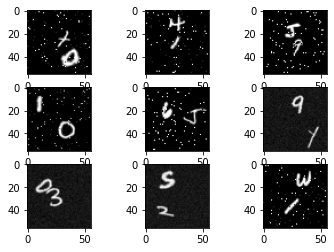

In [108]:
# Print training accuracy
_, acc = predict(model, trainLoader, device)
print(f"Train Accuracy: {acc}")

# Predict on the test set
y_test = convertToPredictions(predict(model, testLoader, device)[0])
print(f"Test Prediction shape: {y_test.shape}")

# Visualize accuracy of test predictions on a few samples
for i in range(9):
  pyplot.subplot(331 + i)
  pyplot.imshow(test[i], cmap=pyplot.get_cmap('gray'))
  print(mapLabelsToCharacters(y_test[i]))
pyplot.show()

# Write file to be submitted locally
prepareForEvaluation("submission.csv", y_test)

# Save model
modelName = f"trainAcc{acc}.pth"
torch.save(model.state_dict(), f"models/{modelName}")

# Bagging

### Single Model Bagging

##### Utils

In [38]:
def mapCharactersToLabels(tup):
  temp = np.zeros((36,), dtype=int)
  temp[tup[0]] = 1
  temp[ord(tup[1])+9-64] = 1
  return temp

In [39]:
def consolidateBaggedPredictions(baggedPredictions):
  modePredicts = []
  noFreqErrCounter = 0
  randomGuessCounter = 0
  # Loop over number of instances (ex. 30,000)
  for i in range(baggedPredictions[0].shape[0]):
    lst = []
    # For each instance, loop through each set of predictions
    for j in baggedPredictions:
      lst.append(mapLabelsToCharacters(j[i]))

    try:
      # If a most frequent prediction is found, append
      freq = mode(lst)
      modePredicts.append(mapCharactersToLabels(freq))
    except:
      # If there is no most frequent prediction, try to find the most frequently predicted number and character independently
      noFreqErrCounter += 1
      numLst = []
      letterLst = []
      for tpl in lst:
        numLst.append(tpl[0])
        letterLst.append(tpl[1])
      try:
        num = mode(numLst)
        letter = mode(letterLst)
        modePredicts.append(mapCharactersToLabels((num, letter)))
      except:
        # If there is no most frequent number or character, randomly select a prediction
        randomGuessCounter += 1
        rnd = random.choice(lst)
        modePredicts.append(mapCharactersToLabels(rnd))

  print(f"Number of instances with no unique mode: {noFreqErrCounter}")
  print(f"Number of instances that had to be randomly guessed: {randomGuessCounter}")
  return np.asarray(modePredicts)

In [109]:
def singleModelBagging(arch, epochs, criterion, device, bootstrapBuckets, bootstrapSampleSize):
  # Create a new train dataset
  tempTrainDataset = MyDataset(tempTrainX, tempTrainY, normalTransform(np.mean(tempTrainX), np.std(tempTrainX)))
  tempTrainDatasetAugmented = getAugmentedDataset(tempTrainX, tempTrainY, optimumHParams["augRatio"], optimumHParams["rotation"])
  trainData = ConcatDataset([tempTrainDataset, tempTrainDatasetAugmented])
  print(f"Training Data has {len(trainData)} instances")

  baggedPredictions = []
  for _ in range(bootstrapBuckets):
    model = ResNet_prod(multiLayer, arch, 1, 36)
    # Create a bootstrapped dataset by randomly sampling from trainData with replacement
    sampler = RandomSampler(trainData, replacement=True, num_samples=int(bootstrapSampleSize * len(trainData)))
    dl = DataLoader(trainData, sampler=sampler, batch_size=batchSize, num_workers=2)

    optimizer = torch.optim.Adam(model.parameters())

    # Train model on bootstrapped dataset
    trainedModel = train(model, dl, epochs, criterion, optimizer, device)

    # Predict on the test set
    yTestBootstrap = convertToPredictions(predict(trainedModel, testLoader, device)[0])
    baggedPredictions.append(yTestBootstrap)
  return baggedPredictions

In [41]:
def sortMostFreq(lst):
  d = {}
  topCount = 0
  for count, elem in sorted(((lst.count(e), e) for e in set(lst)), reverse=True):
    d[elem] = count
    if count > topCount:
      topCount = count

  l = []
  for k in d:
    if d[k] == topCount:
      l.append(k)
  return l

In [42]:
def consolidate(baggedPredictions):
  modePredicts = []
  noFreqErrCounter = 0
  randomGuessCounter = 0
  # Loop over number of instances (ex. 30,000)
  for i in range(baggedPredictions[0].shape[0]):
    lst = []
    # For each instance, loop through each set of predictions
    for j in baggedPredictions:
      lst.append(mapLabelsToCharacters(j[i]))

    try:
      # If a most frequent prediction is found, append
      freq = mode(lst)
      modePredicts.append(mapCharactersToLabels(freq))
    except:
      # If there is no most frequent prediction, try to find the most frequently predicted number and character independently
      noFreqErrCounter += 1
      numLst = []
      letterLst = []
      for tpl in lst:
        numLst.append(tpl[0])
        letterLst.append(tpl[1])

      try:
        num = mode(numLst)
        try:
          letter = mode(letterLst)
          modePredicts.append(mapCharactersToLabels((num, letter)))
        except:
          modePredicts.append(mapCharactersToLabels((num, random.choice(sortMostFreq(letterLst)))))
      except:
        try:
          letter = mode(letterLst)
          modePredicts.append(mapCharactersToLabels((random.choice(sortMostFreq(numLst)), letter)))
        except:
          # If there is no most frequent number or character, randomly select a prediction
          randomGuessCounter += 1
          rndNum = random.choice(sortMostFreq(numLst))
          rndLetter = random.choice(sortMostFreq(letterLst))
          modePredicts.append(mapCharactersToLabels((rndNum, rndLetter)))

  print(f"Number of instances with no unique mode: {noFreqErrCounter}")
  print(f"Number of instances that had to be randomly guessed: {randomGuessCounter}")
  return np.asarray(modePredicts)

##### Run and Evaluate

In [67]:
# Define initial model, epochs, loss function, optimizer, where model will be run, number of bootstrap buckets, and sample size of each bootstrap bucket
baggedInitModel = [3, 4, 6, 3] # ResNet50
baggedEpochs = 30
baggedLossFunction = nn.BCELoss()
baggedDevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
baggedBootstrapBuckets = 7
baggedBootstrapSampleSize = 0.6

# Run single model bagging
baggedSingleModelPredictions = singleModelBagging(baggedInitModel, baggedEpochs, baggedLossFunction, baggedDevice, baggedBootstrapBuckets, baggedBootstrapSampleSize)

Training Data has 33000 instances
Beginning training on cuda:0
[1,    10] loss: 0.001567
[1,    20] loss: 0.001085
[1,    30] loss: 0.001032
[1,    40] loss: 0.001022
[1,    50] loss: 0.001007
[1,    60] loss: 0.000999
[1,    70] loss: 0.000995
Finished epoch 1 with accuracy: 0.017272727272727273
[2,    10] loss: 0.000975
[2,    20] loss: 0.000959
[2,    30] loss: 0.000944
[2,    40] loss: 0.000925
[2,    50] loss: 0.000918
[2,    60] loss: 0.000901
[2,    70] loss: 0.000873
Finished epoch 2 with accuracy: 0.05803030303030303
[3,    10] loss: 0.000846
[3,    20] loss: 0.000815
[3,    30] loss: 0.000785
[3,    40] loss: 0.000754
[3,    50] loss: 0.000733
[3,    60] loss: 0.000687
[3,    70] loss: 0.000676
Finished epoch 3 with accuracy: 0.225
[4,    10] loss: 0.000642
[4,    20] loss: 0.000632
[4,    30] loss: 0.000583
[4,    40] loss: 0.000546
[4,    50] loss: 0.000526
[4,    60] loss: 0.000499
[4,    70] loss: 0.000476
Finished epoch 4 with accuracy: 0.463030303030303
[5,    10] loss:

Number of instances with no unique mode: 220
Number of instances that had to be randomly guessed: 110
Bagged Test Prediction shape: (15000, 36)
(0, 'T')
(4, 'L')
(9, 'J')
(0, 'L')
(6, 'J')
(9, 'Y')
(3, 'O')
(2, 'S')
(1, 'W')


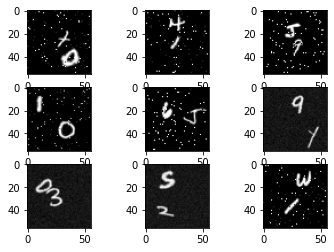

In [72]:
# Consolidate baggedSingleModelPredictions using mode prediction of each instance
baggedTestPredict_S1 = consolidateBaggedPredictions(baggedSingleModelPredictions)
print(f"Bagged Test Prediction shape: {baggedTestPredict_S1.shape}")

# Visualize accuracy of bagged test predictions on a few samples
for i in range(9):
  pyplot.subplot(331 + i)
  pyplot.imshow(test[i], cmap=pyplot.get_cmap('gray'))
  print(mapLabelsToCharacters(baggedTestPredict_S1[i]))
pyplot.show()

# Write file to be submitted locally
prepareForEvaluation("baggedSubmission_S1.csv", baggedTestPredict_S1)

Number of instances with no unique mode: 220
Number of instances that had to be randomly guessed: 5
Bagged Test Prediction shape: (15000, 36)
(0, 'T')
(4, 'L')
(9, 'J')
(0, 'L')
(6, 'J')
(9, 'Y')
(3, 'O')
(2, 'S')
(1, 'W')


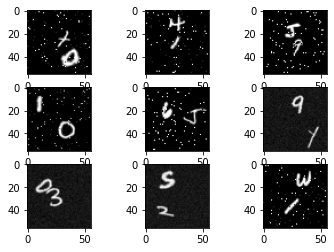

In [112]:
# Consolidate baggedSingleModelPredictions using mode prediction of each instance
baggedTestPredict_S2 = consolidate(baggedSingleModelPredictions)
print(f"Bagged Test Prediction shape: {baggedTestPredict_S2.shape}")

# Visualize accuracy of bagged test predictions on a few samples
for i in range(9):
  pyplot.subplot(331 + i)
  pyplot.imshow(test[i], cmap=pyplot.get_cmap('gray'))
  print(mapLabelsToCharacters(baggedTestPredict_S2[i]))
pyplot.show()

# Write file to be submitted locally
prepareForEvaluation("baggedSubmission_S2.csv", baggedTestPredict_S2)

### Multiple Model Bagging

##### Utils

In [110]:
def modifiedSingleModelBagging(fileTpl, epochs, criterion, device, bootstrapBuckets, bootstrapSampleSize):
  # Create a new train dataset
  tempTrainDataset = MyDataset(tempTrainX, tempTrainY, normalTransform(np.mean(tempTrainX), np.std(tempTrainX)))
  tempTrainDatasetAugmented = getAugmentedDataset(tempTrainX, tempTrainY, optimumHParams["augRatio"], optimumHParams["rotation"])
  trainData = ConcatDataset([tempTrainDataset, tempTrainDatasetAugmented])

  baggedPredictions = []
  for i in range(bootstrapBuckets):
    print(f"Bootstrap bucket {i+1} out of {bootstrapBuckets}")
    if fileTpl[1] == 50:
      model = ResNet_prod(multiLayer, [3, 4, 6, 3], 1, 36).to(device) # ResNet50
    
    if fileTpl[1] == 152:
      model = ResNet_prod(multiLayer, [3, 8, 36, 3], 1, 36).to(device) # ResNet152

    model.load_state_dict(torch.load(f"models/{fileTpl[0]}"))

    # Create a bootstrapped dataset by randomly sampling from trainData with replacement
    sampler = RandomSampler(trainData, replacement=True, num_samples=int(bootstrapSampleSize * len(trainData)))
    dl = DataLoader(trainData, sampler=sampler, batch_size=batchSize, num_workers=2)

    optimizer = torch.optim.Adam(model.parameters())

    # Train model on bootstrapped dataset
    trainedModel = train(model, dl, epochs, criterion, optimizer, device)

    # Predict on the test set
    yTestBootstrap = convertToPredictions(predict(trainedModel, testLoader, device)[0])
    baggedPredictions.append(yTestBootstrap)
  return baggedPredictions

In [111]:
def modifiedMultipleModelBagging(files, epochs, criterion, device, bootstrapBuckets, bootstrapSampleSize):
  baggedPredictions = []
  for i, fileTpl in enumerate(files):
    print(f"Starting model {i+1} with file {fileTpl[0]}")
    modelPredictions = modifiedSingleModelBagging(fileTpl, epochs, criterion, device, bootstrapBuckets, bootstrapSampleSize)
    baggedPredictions.extend(modelPredictions)
  return baggedPredictions

##### Run and Evaluate

In [69]:
# Define initial models, epochs, loss function, optimizer, where model will be run, number of bootstrap buckets, sample size of each bootstrap bucket, and augmentation ratio of train dataset
baggedInitModels = [
                    ("trainAcc0.8840444444444444.pth", 50), # ResNet50
                    ("trainAcc0.9414242424242424.pth", 152), # ResNet152
                    ("trainAcc0.9565454545454546.pth", 50), # ResNet50
                    ]
baggedEpochs = 5
baggedLossFunction = nn.BCELoss()
baggedDevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
baggedBootstrapBuckets = 3
baggedBootstrapSampleSize = 0.6

# Run multiple model bagging
baggedMultipleModelPredictions = modifiedMultipleModelBagging(baggedInitModels, baggedEpochs, baggedLossFunction, baggedDevice, baggedBootstrapBuckets, baggedBootstrapSampleSize)

Starting model 1 with file trainAcc0.8840444444444444.pth
Bootstrap bucket 1 out of 3
Beginning training on cuda:0
[1,    10] loss: 0.000049
[1,    20] loss: 0.000055
[1,    30] loss: 0.000054
[1,    40] loss: 0.000050
[1,    50] loss: 0.000048
[1,    60] loss: 0.000049
[1,    70] loss: 0.000043
Finished epoch 1 with accuracy: 0.961919191919192
[2,    10] loss: 0.000050
[2,    20] loss: 0.000046
[2,    30] loss: 0.000048
[2,    40] loss: 0.000045
[2,    50] loss: 0.000047
[2,    60] loss: 0.000042
[2,    70] loss: 0.000047
Finished epoch 2 with accuracy: 0.9624242424242424
[3,    10] loss: 0.000037
[3,    20] loss: 0.000050
[3,    30] loss: 0.000045
[3,    40] loss: 0.000044
[3,    50] loss: 0.000059
[3,    60] loss: 0.000053
[3,    70] loss: 0.000048
Finished epoch 3 with accuracy: 0.9484343434343434
[4,    10] loss: 0.000054
[4,    20] loss: 0.000050
[4,    30] loss: 0.000056
[4,    40] loss: 0.000047
[4,    50] loss: 0.000052
[4,    60] loss: 0.000051
[4,    70] loss: 0.000042
Finis

Number of instances with no unique mode: 173
Number of instances that had to be randomly guessed: 96
Bagged Test Prediction shape: (15000, 36)
(0, 'T')
(4, 'L')
(9, 'J')
(0, 'L')
(6, 'J')
(9, 'Y')
(3, 'O')
(2, 'S')
(1, 'W')


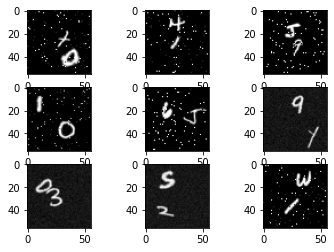

In [82]:
# Consolidate using mode prediction of each instance
baggedTestPredict_M1 = consolidateBaggedPredictions(baggedMultipleModelPredictions)
print(f"Bagged Test Prediction shape: {baggedTestPredict_M1.shape}")

# Visualize accuracy of bagged test predictions on a few samples
for i in range(9):
  pyplot.subplot(331 + i)
  pyplot.imshow(test[i], cmap=pyplot.get_cmap('gray'))
  print(mapLabelsToCharacters(baggedTestPredict_M1[i]))
pyplot.show()

# Write file to be submitted locally
prepareForEvaluation("baggedSubmission_M1.csv", baggedTestPredict_M1)

Number of instances with no unique mode: 173
Number of instances that had to be randomly guessed: 2
Bagged Test Prediction shape: (15000, 36)
(0, 'T')
(4, 'L')
(9, 'J')
(0, 'L')
(6, 'J')
(9, 'Y')
(3, 'O')
(2, 'S')
(1, 'W')


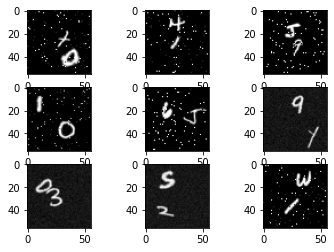

In [83]:
# Consolidate using mode prediction of each instance
baggedTestPredict_M2 = consolidate(baggedMultipleModelPredictions)
print(f"Bagged Test Prediction shape: {baggedTestPredict_M2.shape}")

# Visualize accuracy of bagged test predictions on a few samples
for i in range(9):
  pyplot.subplot(331 + i)
  pyplot.imshow(test[i], cmap=pyplot.get_cmap('gray'))
  print(mapLabelsToCharacters(baggedTestPredict_M2[i]))
pyplot.show()

# Write file to be submitted locally
prepareForEvaluation("baggedSubmission_M2.csv", baggedTestPredict_M2)

# Unlabeled Data

### Init

In [112]:
unlabeledData = MyDataset(unlabeled, None, normalTransform(np.mean(unlabeled), np.std(unlabeled)))
print(f"Unlabeled Data has {len(unlabeledData)} instances")

unlabeledLoader = DataLoader(unlabeledData, batch_size=batchSize, shuffle=False, num_workers=2)
print("Batches in Unlabeled Loader: {}".format(len(unlabeledLoader)))
print("Examples in Unlabeled Loader: {}".format(len(unlabeledLoader.sampler)))

Unlabeled Data has 30000 instances
Batches in Unlabeled Loader: 469
Examples in Unlabeled Loader: 30000


In [113]:
model1 = ResNet_prod(multiLayer, [3, 4, 6, 3], 1, 36).to(device) # ResNet50
model1.load_state_dict(torch.load("models/trainAcc0.8840444444444444.pth"))

model2 = ResNet_prod(multiLayer, [3, 8, 36, 3], 1, 36).to(device) # ResNet152
model2.load_state_dict(torch.load("models/trainAcc0.9414242424242424.pth"))

model3 = ResNet_prod(multiLayer, [3, 4, 6, 3], 1, 36).to(device) # ResNet50
model3.load_state_dict(torch.load("models/trainAcc0.9565454545454546.pth"))

<All keys matched successfully>

In [114]:
model1UnlabeledPredict = convertToPredictions(predict(model1, unlabeledLoader, device)[0])
print(f"Unlabeled Prediction shape: {model1Predict.shape}")

model2UnlabeledPredict = convertToPredictions(predict(model2, unlabeledLoader, device)[0])
print(f"Unlabeled Prediction shape: {model2Predict.shape}")

model3UnlabeledPredict = convertToPredictions(predict(model3, unlabeledLoader, device)[0])
print(f"Unlabeled Prediction shape: {model3Predict.shape}")

unlabeledPredicts = [model1UnlabeledPredict, model2UnlabeledPredict, model3UnlabeledPredict]

Unlabeled Prediction shape: (15000, 36)
Unlabeled Prediction shape: (15000, 36)
Unlabeled Prediction shape: (15000, 36)


### Run and Evaluate

Number of instances with no unique mode: 1206
Number of instances that had to be randomly guessed: 101
Unlabeled Prediction shape: (30000, 36)
(6, 'S')
(1, 'F')
(1, 'K')
(4, 'I')
(7, 'I')
(7, 'Q')
(6, 'G')
(0, 'K')
(3, 'I')


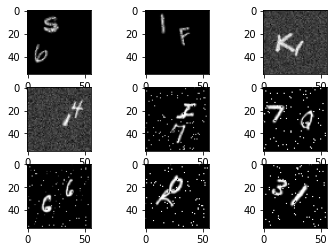

Training Data With Unlabeled has 67500 instances


In [115]:
# Consolidate using mode prediction of each instance
unlabeledYPredict = consolidate(unlabeledPredicts)
print(f"Unlabeled Prediction shape: {unlabeledYPredict.shape}")

# Visualize accuracy of unlabeled predictions on a few samples
for i in range(9):
  pyplot.subplot(331 + i)
  pyplot.imshow(unlabeled[i], cmap=pyplot.get_cmap('gray'))
  print(mapLabelsToCharacters(unlabeledYPredict[i]))
pyplot.show()

unlabeledDataset = MyDataset(unlabeled, unlabeledYPredict, normalTransform(np.mean(unlabeled), np.std(unlabeled)))
trainDataWithUnlabeled = ConcatDataset([tempTrainDataset, tempTrainDatasetAugmented, unlabeledDataset])
print(f"Training Data With Unlabeled has {len(trainDataWithUnlabeled)} instances")

trainWithUnlabeledLoader = DataLoader(trainDataWithUnlabeled, batch_size=batchSize, shuffle=True, num_workers=2)

In [116]:
# Train model
initModel = ResNet_prod(multiLayer, [3, 4, 6, 3], 1, 36)
numberOfEpochs = 50
optimizerType = torch.optim.Adam(initModel.parameters())
modelWithUnlabeled = train(initModel, trainWithUnlabeledLoader, numberOfEpochs, nn.BCELoss(), optimizerType, device)

Streaming output truncated to the last 5000 lines.
[3,   900] loss: 0.000215
[3,   910] loss: 0.000209
[3,   920] loss: 0.000234
[3,   930] loss: 0.000222
[3,   940] loss: 0.000217
[3,   950] loss: 0.000217
[3,   960] loss: 0.000225
[3,   970] loss: 0.000238
[3,   980] loss: 0.000247
[3,   990] loss: 0.000228
[3,  1000] loss: 0.000240
[3,  1010] loss: 0.000240
[3,  1020] loss: 0.000194
[3,  1030] loss: 0.000226
[3,  1040] loss: 0.000214
[3,  1050] loss: 0.000259
Finished epoch 3 with accuracy: 0.7567851851851852
[4,    10] loss: 0.000289
[4,    20] loss: 0.000242
[4,    30] loss: 0.000207
[4,    40] loss: 0.000193
[4,    50] loss: 0.000204
[4,    60] loss: 0.000198
[4,    70] loss: 0.000240
[4,    80] loss: 0.000234
[4,    90] loss: 0.000201
[4,   100] loss: 0.000219
[4,   110] loss: 0.000190
[4,   120] loss: 0.000207
[4,   130] loss: 0.000197
[4,   140] loss: 0.000218
[4,   150] loss: 0.000196
[4,   160] loss: 0.000185
[4,   170] loss: 0.000198
[4,   180] loss: 0.000203
[4,   190] los

Train Accuracy: 0.9801777777777778
Test Prediction shape: (15000, 36)
(0, 'T')
(4, 'L')
(7, 'J')
(0, 'L')
(6, 'J')
(9, 'Y')
(3, 'O')
(2, 'S')
(1, 'W')


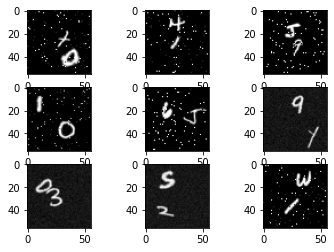

In [120]:
# Print training accuracy
_, acc = predict(modelWithUnlabeled, trainWithUnlabeledLoader, device)
print(f"Train Accuracy: {acc}")

# Predict on the test set
y_test_ul = convertToPredictions(predict(modelWithUnlabeled, testLoader, device)[0])
print(f"Test Prediction shape: {y_test_ul.shape}")

# Visualize accuracy of test predictions on a few samples
for i in range(9):
  pyplot.subplot(331 + i)
  pyplot.imshow(test[i], cmap=pyplot.get_cmap('gray'))
  print(mapLabelsToCharacters(y_test_ul[i]))
pyplot.show()

# Write file to be submitted locally
prepareForEvaluation("submissionwithUl.csv", y_test_ul)

In [124]:
# Save model
modelName = f"trainAcc{acc}.pth"
torch.save(modelWithUnlabeled.state_dict(), f"models/{modelName}")

### Single Model Bagging

##### Utils

In [143]:
def singleModelBaggingUl(arch, trainData, epochs, criterion, device, bootstrapBuckets, bootstrapSampleSize):
  print(f"Training Data has {len(trainData)} instances")

  baggedPredictions = []
  for _ in range(bootstrapBuckets):
    model = ResNet_prod(multiLayer, arch, 1, 36)
    # Create a bootstrapped dataset by randomly sampling from trainData with replacement
    sampler = RandomSampler(trainData, replacement=True, num_samples=int(bootstrapSampleSize * len(trainData)))
    dl = DataLoader(trainData, sampler=sampler, batch_size=batchSize, num_workers=2)

    optimizer = torch.optim.Adam(model.parameters())

    # Train model on bootstrapped dataset
    trainedModel = train(model, dl, epochs, criterion, optimizer, device)

    # Predict on the test set
    yTestBootstrap = convertToPredictions(predict(trainedModel, testLoader, device)[0])
    baggedPredictions.append(yTestBootstrap)
  return baggedPredictions

##### Run and Evaluate

In [147]:
# Define initial model, epochs, loss function, optimizer, where model will be run, number of bootstrap buckets, and sample size of each bootstrap bucket
baggedInitModel = [3, 4, 6, 3] # ResNet50
baggedEpochs = 20
baggedLossFunction = nn.BCELoss()
baggedDevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
baggedBootstrapBuckets = 3
baggedBootstrapSampleSize = 0.6

# Run single model bagging
baggedSingleModelUlPredictions = singleModelBaggingUl(baggedInitModel, trainDataWithUnlabeled, baggedEpochs, baggedLossFunction, baggedDevice, baggedBootstrapBuckets, baggedBootstrapSampleSize)

Training Data has 67500 instances
Beginning training on cuda:0
[1,    10] loss: 0.001575
[1,    20] loss: 0.001138
[1,    30] loss: 0.001087
[1,    40] loss: 0.001084
[1,    50] loss: 0.001069
[1,    60] loss: 0.001053
[1,    70] loss: 0.001048
[1,    80] loss: 0.001040
[1,    90] loss: 0.001036
[1,   100] loss: 0.001021
[1,   110] loss: 0.001014
[1,   120] loss: 0.001013
[1,   130] loss: 0.001000
[1,   140] loss: 0.000993
[1,   150] loss: 0.000992
[1,   160] loss: 0.000990
[1,   170] loss: 0.000967
[1,   180] loss: 0.000961
[1,   190] loss: 0.000967
[1,   200] loss: 0.000958
[1,   210] loss: 0.000967
[1,   220] loss: 0.000953
[1,   230] loss: 0.000948
[1,   240] loss: 0.000922
[1,   250] loss: 0.000916
[1,   260] loss: 0.000913
[1,   270] loss: 0.000914
[1,   280] loss: 0.000901
[1,   290] loss: 0.000906
[1,   300] loss: 0.000911
[1,   310] loss: 0.000897
[1,   320] loss: 0.000860
[1,   330] loss: 0.000860
[1,   340] loss: 0.000860
[1,   350] loss: 0.000850
[1,   360] loss: 0.000847
[

Number of instances with no unique mode: 383
Number of instances that had to be randomly guessed: 243
Bagged Unlabeled Prediction shape: (15000, 36)
(0, 'T')
(4, 'L')
(9, 'P')
(0, 'L')
(6, 'J')
(9, 'Y')
(3, 'O')
(2, 'S')
(1, 'W')


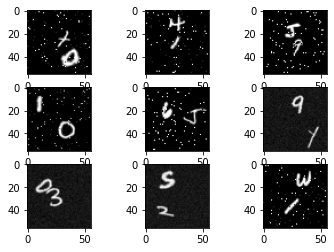

In [148]:
# Consolidate baggedSingleModelPredictions using mode prediction of each instance
baggedTestPredict_Ul1 = consolidateBaggedPredictions(baggedSingleModelUlPredictions)
print(f"Bagged Unlabeled Prediction shape: {baggedTestPredict_Ul1.shape}")

# Visualize accuracy of bagged unlabeled predictions on a few samples
for i in range(9):
  pyplot.subplot(331 + i)
  pyplot.imshow(test[i], cmap=pyplot.get_cmap('gray'))
  print(mapLabelsToCharacters(baggedTestPredict_Ul1[i]))
pyplot.show()

# Write file to be submitted locally
prepareForEvaluation("baggedSubmission_Ul1.csv", baggedTestPredict_Ul1)

Number of instances with no unique mode: 383
Number of instances that had to be randomly guessed: 12
Bagged Unlabeled Prediction shape: (15000, 36)
(0, 'T')
(4, 'L')
(9, 'P')
(0, 'L')
(6, 'J')
(9, 'Y')
(3, 'O')
(2, 'S')
(1, 'W')


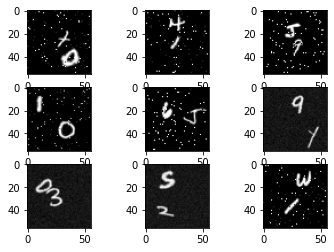

In [149]:
# Consolidate baggedSingleModelPredictions using mode prediction of each instance
baggedTestPredict_Ul2 = consolidate(baggedSingleModelUlPredictions)
print(f"Bagged Unlabeled Prediction shape: {baggedTestPredict_Ul2.shape}")

# Visualize accuracy of bagged unlabeled predictions on a few samples
for i in range(9):
  pyplot.subplot(331 + i)
  pyplot.imshow(test[i], cmap=pyplot.get_cmap('gray'))
  print(mapLabelsToCharacters(baggedTestPredict_Ul2[i]))
pyplot.show()

# Write file to be submitted locally
prepareForEvaluation("baggedSubmission_Ul2.csv", baggedTestPredict_Ul2)

### Multiple Model Bagging

##### Utils

In [131]:
def modifiedSingleModelBaggingUl(fileTpl, epochs, criterion, device, bootstrapBuckets, bootstrapSampleSize):
  # Create a new train dataset
  tempTrainDataset = MyDataset(tempTrainX, tempTrainY, normalTransform(np.mean(tempTrainX), np.std(tempTrainX)))
  tempTrainDatasetAugmented = getAugmentedDataset(tempTrainX, tempTrainY, optimumHParams["augRatio"], optimumHParams["rotation"])
  unlabeledDataset = MyDataset(unlabeled, unlabeledYPredict, normalTransform(np.mean(unlabeled), np.std(unlabeled)))
  trainData = ConcatDataset([tempTrainDataset, tempTrainDatasetAugmented, unlabeledDataset])

  baggedPredictions = []
  for i in range(bootstrapBuckets):
    print(f"Bootstrap bucket {i+1} out of {bootstrapBuckets}")
    if fileTpl[1] == 50:
      model = ResNet_prod(multiLayer, [3, 4, 6, 3], 1, 36).to(device) # ResNet50
    
    if fileTpl[1] == 152:
      model = ResNet_prod(multiLayer, [3, 8, 36, 3], 1, 36).to(device) # ResNet152

    model.load_state_dict(torch.load(f"models/{fileTpl[0]}"))

    # Create a bootstrapped dataset by randomly sampling from trainData with replacement
    sampler = RandomSampler(trainData, replacement=True, num_samples=int(bootstrapSampleSize * len(trainData)))
    dl = DataLoader(trainData, sampler=sampler, batch_size=batchSize, num_workers=2)

    optimizer = torch.optim.Adam(model.parameters())

    # Train model on bootstrapped dataset
    trainedModel = train(model, dl, epochs, criterion, optimizer, device)

    # Predict on the test set
    yTestBootstrap = convertToPredictions(predict(trainedModel, testLoader, device)[0])
    baggedPredictions.append(yTestBootstrap)
  return baggedPredictions

In [132]:
def modifiedMultipleModelBaggingUl(files, epochs, criterion, device, bootstrapBuckets, bootstrapSampleSize):
  baggedPredictions = []
  for i, fileTpl in enumerate(files):
    print(f"Starting model {i+1} with file {fileTpl[0]}")
    modelPredictions = modifiedSingleModelBaggingUl(fileTpl, epochs, criterion, device, bootstrapBuckets, bootstrapSampleSize)
    baggedPredictions.extend(modelPredictions)
  return baggedPredictions

##### Run and Evaluate

In [136]:
# Define initial models, epochs, loss function, optimizer, where model will be run, number of bootstrap buckets, sample size of each bootstrap bucket, and augmentation ratio of train dataset
baggedInitModels = [
                    ("trainAcc0.8401.pth", 50), #ResNet50
                    ("trainAcc0.8840444444444444.pth", 50), # ResNet50
                    ("trainAcc0.9565454545454546.pth", 50), # ResNet50
                    ("trainAcc0.9654666666666667.pth", 50), # ResNet50
                    ("trainAcc0.9801777777777778.pth", 50), # ResNet50
                    ]
baggedEpochs = 3
baggedLossFunction = nn.BCELoss()
baggedDevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
baggedBootstrapBuckets = 3
baggedBootstrapSampleSize = 0.6

# Run multiple model bagging
baggedMultipleModelPredictionsUl = modifiedMultipleModelBaggingUl(baggedInitModels, baggedEpochs, baggedLossFunction, baggedDevice, baggedBootstrapBuckets, baggedBootstrapSampleSize)

Starting model 1 with file trainAcc0.8401.pth
Bootstrap bucket 1 out of 3
Beginning training on cuda:0
[1,    10] loss: 0.000131
[1,    20] loss: 0.000122
[1,    30] loss: 0.000094
[1,    40] loss: 0.000116
[1,    50] loss: 0.000111
[1,    60] loss: 0.000098
[1,    70] loss: 0.000100
[1,    80] loss: 0.000085
[1,    90] loss: 0.000096
[1,   100] loss: 0.000075
[1,   110] loss: 0.000102
[1,   120] loss: 0.000104
[1,   130] loss: 0.000122
[1,   140] loss: 0.000103
[1,   150] loss: 0.000111
[1,   160] loss: 0.000096
[1,   170] loss: 0.000100
[1,   180] loss: 0.000121
[1,   190] loss: 0.000121
[1,   200] loss: 0.000116
[1,   210] loss: 0.000106
[1,   220] loss: 0.000101
[1,   230] loss: 0.000088
[1,   240] loss: 0.000080
[1,   250] loss: 0.000106
[1,   260] loss: 0.000099
[1,   270] loss: 0.000089
[1,   280] loss: 0.000097
[1,   290] loss: 0.000085
[1,   300] loss: 0.000073
[1,   310] loss: 0.000105
[1,   320] loss: 0.000096
[1,   330] loss: 0.000075
[1,   340] loss: 0.000117
[1,   350] lo

Number of instances with no unique mode: 74
Number of instances that had to be randomly guessed: 34
Bagged Test Prediction shape: (15000, 36)
(0, 'T')
(4, 'L')
(9, 'J')
(0, 'L')
(6, 'J')
(9, 'Y')
(3, 'O')
(2, 'S')
(1, 'W')


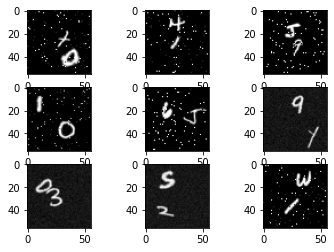

In [141]:
# Consolidate using mode prediction of each instance
baggedTestPredict_M1Ul = consolidateBaggedPredictions(baggedMultipleModelPredictionsUl)
print(f"Bagged Test Prediction shape: {baggedTestPredict_M1Ul.shape}")

# Visualize accuracy of bagged test predictions on a few samples
for i in range(9):
  pyplot.subplot(331 + i)
  pyplot.imshow(test[i], cmap=pyplot.get_cmap('gray'))
  print(mapLabelsToCharacters(baggedTestPredict_M1Ul[i]))
pyplot.show()

# Write file to be submitted locally
prepareForEvaluation("baggedSubmission_M1Ul.csv", baggedTestPredict_M1Ul)

Number of instances with no unique mode: 74
Number of instances that had to be randomly guessed: 0
Bagged Test Prediction shape: (15000, 36)
(0, 'T')
(4, 'L')
(9, 'J')
(0, 'L')
(6, 'J')
(9, 'Y')
(3, 'O')
(2, 'S')
(1, 'W')


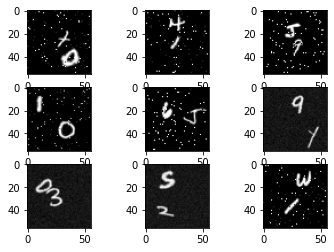

In [142]:
# Consolidate using mode prediction of each instance
baggedTestPredict_M2Ul = consolidate(baggedMultipleModelPredictionsUl)
print(f"Bagged Test Prediction shape: {baggedTestPredict_M2Ul.shape}")

# Visualize accuracy of bagged test predictions on a few samples
for i in range(9):
  pyplot.subplot(331 + i)
  pyplot.imshow(test[i], cmap=pyplot.get_cmap('gray'))
  print(mapLabelsToCharacters(baggedTestPredict_M2Ul[i]))
pyplot.show()

# Write file to be submitted locally
prepareForEvaluation("baggedSubmission_M2Ul.csv", baggedTestPredict_M2Ul)